## **Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to a HOG feature vector. 
* Normalize features and randomize a selection for training and testing.
* Implement a sliding-window technique and use a trained classifier to search for vehicles in images.
* Run a pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import utils
import vehicle
%matplotlib inline

### Load in vehicles and non-vehicles data sets

Number of vehicle files: 8792
Number of non-vehicle files: 8968


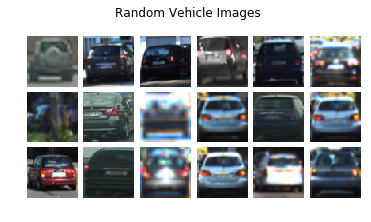

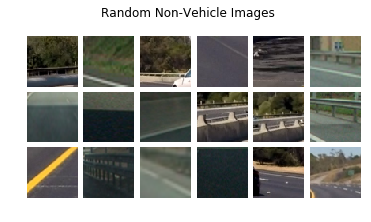

In [2]:
vehicle_files_dir = './data/vehicles/'
non_vehicle_files_dir = './data/non-vehicles/'

vehicle_files = utils.extract_files(vehicle_files_dir)
vehicle_images = [mpimg.imread(file) for file in vehicle_files]

non_vehicle_files = utils.extract_files(non_vehicle_files_dir)
non_vehicle_images = [mpimg.imread(file) for file in non_vehicle_files] 

print('Number of vehicle files: {}'.format(len(vehicle_files)))
print('Number of non-vehicle files: {}'.format(len(non_vehicle_files)))

utils.display_random_images(vehicle_files, num_images=18, main_title='Random Vehicle Images')
utils.display_random_images(non_vehicle_files, num_images=18, main_title='Random Non-Vehicle Images')

### Visualize HOG features

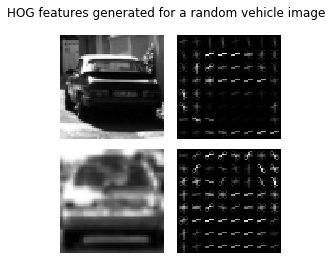

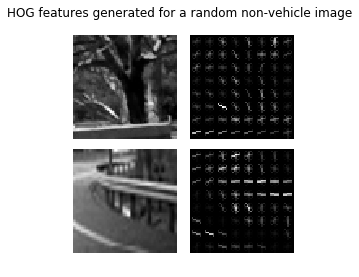

In [6]:
vehicles = []
vehicles_hog_features = []

for i in range(2):
    random_idx = np.random.randint(1, len(vehicle_files))
    image = mpimg.imread(vehicle_files[random_idx])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    features, hog_image = vehicle.get_hog_features(gray, orient, pix_per_cell, cell_per_block, 
                                                   vis=True, feature_vec=False)
    vehicles.append(hog_image)
    vehicles_hog_features.append(gray)

utils.visualize_hog_features(vehicles, 
                             vehicles_hog_features, 
                             color_map='gray', 
                             suptitle='HOG features generated for a random vehicle image')

non_vehicles = []
non_vehicles_hog_features = []

for i in range(2):
    random_idx = np.random.randint(1, len(non_vehicle_files))
    image = mpimg.imread(non_vehicle_files[random_idx])
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    features, hog_image = vehicle.get_hog_features(gray, orient, pix_per_cell, cell_per_block, 
                                                   vis=True, feature_vec=False)
    non_vehicles.append(hog_image)
    non_vehicles_hog_features.append(gray)

utils.visualize_hog_features(non_vehicles, 
                             non_vehicles_hog_features, 
                             color_map='gray', 
                             suptitle='HOG features generated for a random non-vehicle image')

### Draw all sliding windows on test image

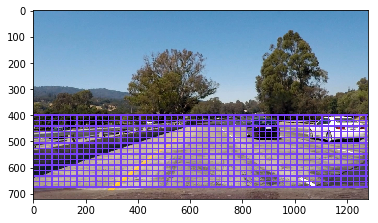

In [7]:
img_path = './test_images/test1.jpg'
image = mpimg.imread(img_path)
image1 = np.copy(image)

windows = vehicle.slide_window(image1, xy_window=(96, 85), xy_overlap=(0.75, 0.75), y_start_stop=[400, 650])
img = utils.draw_sliding_windows(image, windows)
plt.imshow(img)
plt.show()

### Train multiple SVM models to find the best hyper-parameters

In [ ]:
color_space = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9               # HOG orientations
pix_per_cell = 8         # HOG pixels per cell
cell_per_block = 2       # HOG cells per block
hog_channel = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32           # Number of histogram bins
spatial_feat = True      # Spatial features on or off
hist_feat = True         # Histogram features on or off
hog_feat = True          # HOG features on or off

Cs = [0.8, 0.9, 1, 1.1, 1.2]
gammas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
penalties = ['l2']
losses = ['hinge', 'squared_hinge']
training_accuracies = []
validation_accuracies = []
best_C = 1.0
best_penalty = 'l2'
best_loss = 'hinge'
best_accuracy = 0.0

vehicle_features = vehicle.extract_features(vehicle_images, color_space, orient, spatial_size, 
                                            hist_bins, pix_per_cell, cell_per_block, spatial_feat, 
                                            hist_feat, hog_feat, hog_channel)
print('Shape of vehicle features: {}'.format(vehicle_features.shape))

non_vehicle_features = vehicle.extract_features(non_vehicle_images, color_space, orient, spatial_size,
                                                hist_bins, pix_per_cell, cell_per_block, spatial_feat,
                                                hist_feat, hog_feat, hog_channel)
print('Shape of non-vehicle features: {}'.format(non_vehicle_features.shape))

X_features = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
y_features = np.hstack((np.ones(len(vehicle_images)), np.zeros(len(non_vehicle_images))))
print('Shape of dataset: {}'.format(features.shape))

for C in Cs:
    for penalty in penalties:
        for loss in losses:
            X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                                y_features, 
                                                                test_size=0.3, 
                                                                random_state=2048)

            scaler = StandardScaler().fit(X_train)
            X_train = scaler.transform(X_train)            
            X_test = scaler.transform(X_test)
            svc = LinearSVC(C=C, penalty=penalty, loss=loss).fit(X_train, y_train)

            accuracy = svc.score(X_test, y_test)
            print('Validation accuracy: {:.4f}, C: {}, penalty: {}, loss: {}'.format(accuracy, C, penalty, loss))

            if best_accuracy < accuracy:
                best_accuracy = accuracy                
                best_C = C
                best_loss = loss
                best_penalty = penalty

            validation_accuracies.append(accuracy)
            training_accuracies.append(svc.score(X_train, y_train))

print('Best validation accuracy: {:.4f}'.format(best_accuracy))
print('Best hyper-parameters: C: {}, penalty: {}, loss: {}'.format(best_C, best_penalty, best_loss))
print('Build classifier using best hyper-parameters')

scaler = StandardScaler().fit(X_features)
X_features = scaler.transform(X_features)
svc = LinearSVC(C=best_C, penalty=best_penalty, loss=best_loss).fit(X_features, y_features)

### Use SVM model on test image

In [ ]:
img_path = './test_images/test1.jpg'
image = mpimg.imread(img_path)
image1 = np.copy(image)
image = image.astype(np.float32) / 255.0

y_start_stop = [400, 600]  # min, max in y to search in sliding windows

windows = vehicle.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                               xy_window=(96, 85), xy_overlap=(0.75, 0.75))

hot_windows = vehicle.search_windows(image, windows, svc, scaler, color_space=color_space,
                                      spatial_size=spatial_size, hist_bins=hist_bins,
                                      orient=orient, pix_per_cell=pix_per_cell,
                                      cell_per_block=cell_per_block,
                                      hog_channel=hog_channel, spatial_feat=spatial_feat,
                                      hist_feat=hist_feat, hog_feat=hog_feat)

window_image = utils.draw_boxes(image1, hot_windows, color=(119, 65, 244), thick=3)

plt.imshow(window_image)
plt.axis('off')
plt.show()
heat_map = np.zeros_like(image)
heat_map = utils.add_heat(heat_map, hot_windows)
plt.imshow(heat_map, cmap='hot')
plt.axis('off')
plt.show()

### Apply thresholded heat map to remove multiple detections and false positives

In [ ]:
x_start_stop = [None, None]
y_start_stop = [400,600] 
xy_window = (96, 85)
xy_overlap = (0.75, 0.75)

index = 0
plt.figure(figsize=(15, 30))
gs = gridspec.GridSpec(6, 1)
gs.update(wspace=0.5, hspace=0.2)

for file in os.listdir('test_images/'):
    vehicle_detector = vehicle.VehicleDetector(color_space=color_space,
                                               orient=orient,
                                               pix_per_cell=pix_per_cell,
                                               cell_per_block=cell_per_block,
                                               hog_channel=hog_channel,
                                               spatial_size=spatial_size,
                                               hist_bins=hist_bins,
                                               spatial_feat=spatial_feat,
                                               hist_feat=hist_feat,
                                               hog_feat=hog_feat,
                                               y_start_stop=y_start_stop,
                                               x_start_stop=x_start_stop,
                                               xy_window=xy_window,
                                               xy_overlap=xy_overlap,
                                               heat_threshold=1,
                                               scaler=scaler,
                                               classifier=svc) 
    test_image = mpimg.imread('test_images/' + file)
    output = vehicle_detector.detect(test_image)    
    ax1 = plt.subplot(gs[index])
    ax1.axis('off')
    ax1.set_title('{} - Vehicle Detection'.format(file))
    ax1.imshow(output)
    index += 1
       
plt.show()

### Apply pipeline to project video

In [ ]:
output = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
video_clip = clip.fl_image(vehicle_detector.detect) 
%time video_clip.write_videofile(output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))